# Home Pricing Using k-NN with Analysis

We are given the task to build a pricing algorithm based on historical closing prices. We will use a weighted k(=4) nearest neighbor classifier and we'll go though some analysis on the performance of the algorithm. 

First lets load the data using Pandas. We'll notice that every row contains the following attributes ['latitude', 'longitude', 'close_date', 'close_price'].

We split the data into training and test sets. One important thing to be aware of is a home j should only be used to calclate home i's price if the close date of j occurred prior to the close date of i. For this reason we sort the training set by close_date so that we can quickly find the valid homes by binary search.

**There were some rows with a negative 'close_price' im not sure what this may have corresponded to but they were ignored for this analysis**

In [31]:
import pandas as pd
from datetime import datetime
import numpy as np
import math

k=4 

test_size_ratio = 0.10
df = pd.read_csv('data.csv')
df = df[df['close_price'] > 0.0]

house_price_objects = []
for idx, row in df.iterrows():
    row = row.to_dict()
    row['close_price'] = round(row['close_price'], 2)
    row['close_date'] = datetime.strptime(row['close_date'], '%Y-%m-%d %H:%M:%S.%f')
    
    house_price_objects.append(row)

df = pd.DataFrame(house_price_objects)
np.random.shuffle(house_price_objects)
split_index = math.floor(len(house_price_objects)*test_size_ratio)
train_set = house_price_objects[0:-split_index]
test_set = house_price_objects[-split_index:]

train_set = sorted(train_set, key=lambda x: x['close_date'])
train_dates = [entry['close_date'] for entry in train_set]
train_pos = np.array([[entry['latitude'], entry['longitude']] for entry in train_set])


Now lets write the main functions we will be calling to predict the house prices. The algortihm will compute the price from a weighted sum of the k closeset homes by location. The weights will be a normalized version of the reciprocal of the distances.

Finally we will evaluate our models with the Median Relative Absolute Error (MRAE) metric.

In [60]:
import bisect

def get_k_nearest_neighbor(house_object, k):
    
    date_end_index = bisect.bisect_right(train_dates, house_object['close_date'])
    filtered_houses = train_pos[0:date_end_index,:]
    house_pos = np.array([house_object['latitude'], house_object['longitude']])
    residuals = np.abs(filtered_houses - house_pos)
    distances = np.linalg.norm(residuals, axis=1)
    
    k_nearest_index = np.argpartition(distances, k)[0:k] if k < distances.shape[0] else range(distances.shape[0])
    k_nearest_neighbor = [train_set[index] for index in k_nearest_index]
    
    return k_nearest_neighbor, distances[k_nearest_index]

def get_weights(distances):
    
    # check for 0 distance
    for i, entry in enumerate(distances):
          if entry == 0:
                distances[i] = 1*10**-10

    inv_distance = 1/distances
    normalized_inv_distance = inv_distance/np.sum(inv_distance)
    return normalized_inv_distance
 
def predict_price(house_object, k):
    
    k_nearest_neighbor, distances = get_k_nearest_neighbor(house_object, k)
    close_prices = np.array([entry['close_price'] for entry in k_nearest_neighbor])
    weights = get_weights(distances)
    price = np.dot(close_prices, weights)
    
    return price

def median_relative_abs_error(close_prices, predictions):
    
    abs_residuals = np.abs(predictions - close_prices)
    relative_residuals = abs_residuals / close_prices
    return np.median(relative_residuals, axis=0)


In [61]:
test_close_prices = np.array([entry['close_price'] for entry in test_set])
predictions = np.array([predict_price(entry, k) for entry in test_set])
MRAE = median_relative_abs_error(test_close_prices, predictions)
print("k-NN results:")
print("k = ", k)
print("Training examples: ", len(train_set))
print("Test examples: ", len(test_set))
print("MRAE: ", MRAE)

test_df = pd.DataFrame(test_set)
relative_error = np.abs(predictions - test_close_prices) / test_close_prices
test_df['relative_error'] = pd.Series(relative_error, index=test_df.index)
test_df['prediction'] = pd.Series(predictions, index=test_df.index)


k-NN results:
k =  4
Training examples:  77282
Test examples:  8586
MRAE:  0.198915455378


Although we have chosen to use k=4 a more appropriate methodology would be to tune this hyperparameter with k-Fold cross validation

Next lets see if we can say anything about the types of errors the algorithm is making.

Lets try to visualize the relative errors in a heatmap along the spatial axes.

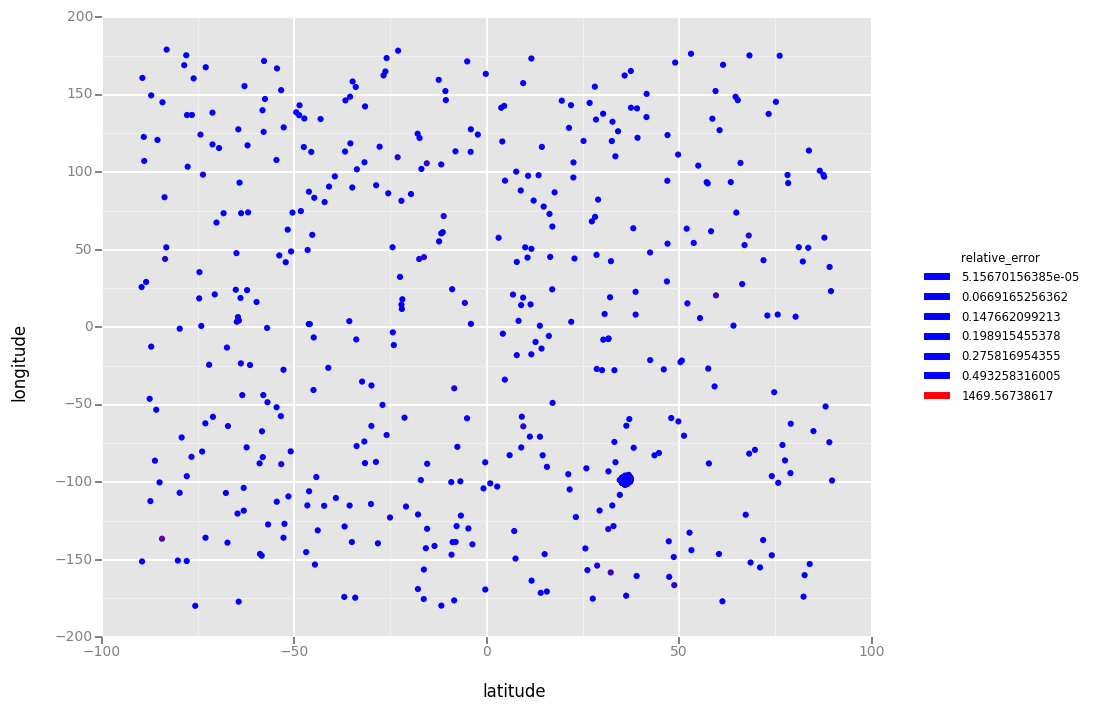

<ggplot: (-9223372036564488774)>


In [65]:
%matplotlib inline
from ggplot import *

heatmap_of_errors = ggplot(test_df, aes(x='latitude', y='longitude', color='relative_error')) +\
    geom_point() +\
    scale_color_gradient(low = 'blue', high = 'red')
print(heatmap_of_errors)

There seems to be quite a large range in the errors so lets do some thresholding to see where we are making the biggest errors. We'll replot but this time only relative errors above 2.   

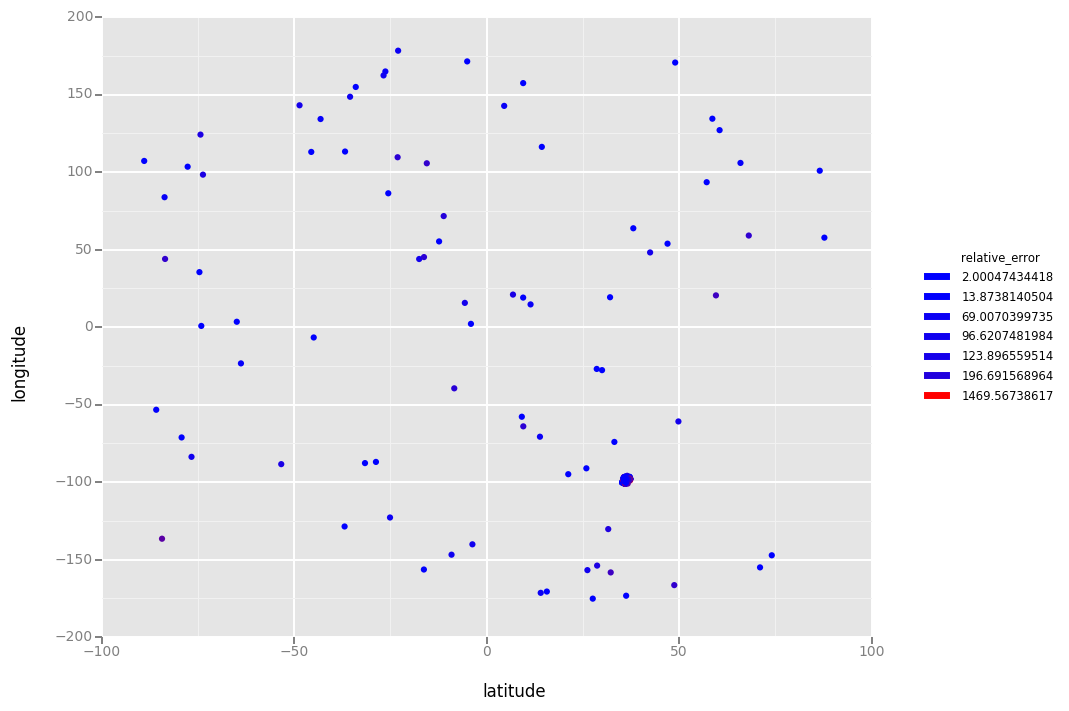

<ggplot: (291592943)>


In [66]:
heatmap_of_errors = ggplot(test_df[test_df['relative_error'] > 2.0], aes(x='latitude', y='longitude', color='relative_error')) +\
    geom_point() +\
    scale_color_gradient(low = 'blue', high = 'red')
print(heatmap_of_errors)


Looks like there is a small cluster of bad predictions down in the bottom right lets zoom in there and see if we can make sense of it.

In [64]:
neighbor_prices = []
std_of_neighbor_prices = []
neighbor_distances = []
for entry in test_set:
    k_neighbors, distances = get_k_nearest_neighbor(entry, k)
    close_prices = list(map(lambda x: x['close_price'], k_neighbors))
    
    neighbor_prices.append(close_prices)
    neighbor_distances.append(distances)                  
    
    std = np.std(close_prices)
    std_of_neighbor_prices.append(std)

test_df['std_of_neighbor_prices'] = pd.Series(std_of_neighbor_prices, index=test_df.index)
test_df['neighbor_prices'] = pd.Series(neighbor_prices, index=test_df.index)
test_df['neighbor_distances'] = pd.Series(neighbor_distances, index=test_df.index)

filtered_df = test_df[(test_df['longitude'] < -80) & (test_df['longitude'] > -120) & (test_df['latitude'] < 40) & (test_df['latitude'] > 30)]

filtered_df[filtered_df['relative_error'] >= 100][['relative_error','close_price','prediction','std_of_neighbor_prices', 'neighbor_prices']].head(10)

,relative_error,close_price,prediction,std_of_neighbor_prices,neighbor_prices
33,172.845839,308066.92,5.355615e+07,4.354807e+07,"[271434.18, 100855317.0, 284994.71, 299631.62]"
36,282.769830,101595.14,2.882964e+07,4.341055e+07,"[100343734.0, 85413.87, 97637.51, 91017.64]"
48,730.480144,128529.45,9.401674e+07,5.027356e+07,"[100861132.0, 100529922.0, 119002.24, 178379.13]"
55,187.033097,130472.11,2.453307e+07,4.364948e+07,"[118354.18, 224029.62, 133230.28, 100962644.0]"
84,453.458648,35076.76,1.594094e+07,4.362626e+07,"[90405.91, 94785.81, 100836900.0, 73918.11]"
86,570.137539,98101.21,5.602928e+07,4.343433e+07,"[97493.85, 107184.32, 100397053.0, 64612.47]"
97,157.949565,130660.04,2.076836e+07,4.346126e+07,"[162903.54, 131192.28, 100518843.0, 154013.67]"
99,322.225328,131908.32,4.263611e+07,5.011824e+07,"[174304.11, 216985.25, 100275244.0, 100588519.0]"
135,107.124066,159394.36,1.723437e+07,4.362659e+07,"[100930452.0, 169387.73, 195957.42, 172161.2]"
170,222.230929,188144.42,4.199965e+07,4.334543e+07,"[97949.91, 100217888.0, 177508.49, 72391.83]"


For these homes there seems to be alot of variance in the prices of the homes close to them. There may be some extra features needed to explain this variance.

Lets now look at any temporal trends in error.

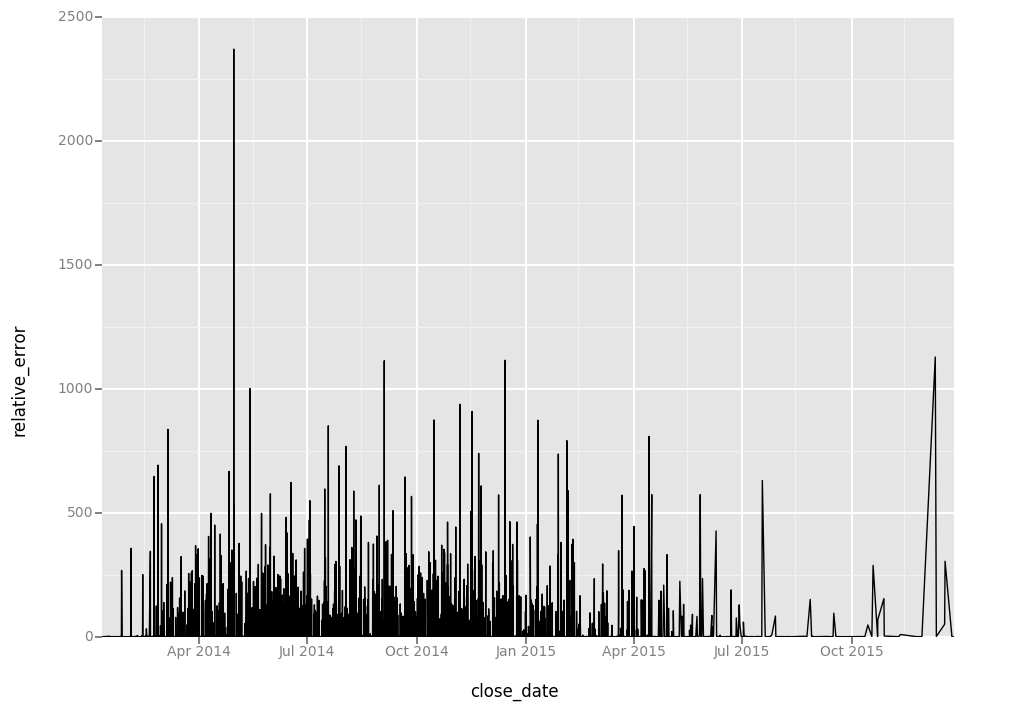

<ggplot: (289838768)>


In [45]:
price_timeseries = ggplot(test_df, aes(x='close_date', y='relative_error')) + geom_line() + \
  scale_x_date(format = "%Y-%m-%d %H:%M:%S")

print(price_timeseries)    

We can see the homes that are more recent have a smaller relative error. There is a clear reason for this, namely that recent homes have more data points to choose from. With more data points we can expect the k nearest neighbors to be closer to the home we want to predict a price for. Lets visualize the average neighbor distance to see this

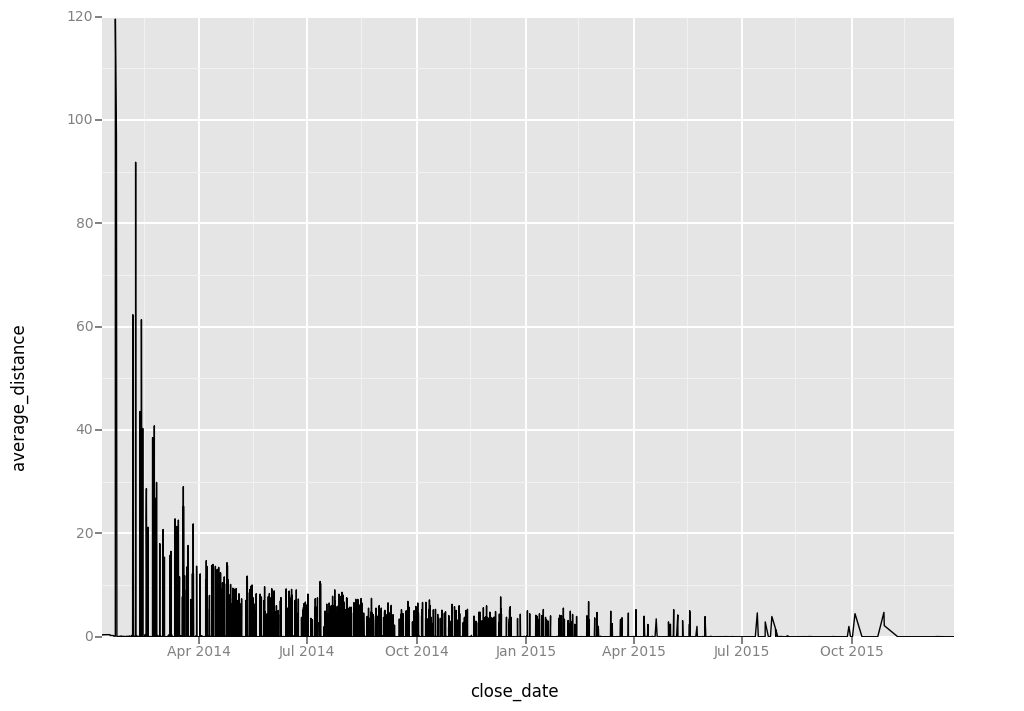

<ggplot: (302533310)>


In [58]:
test_df['average_distance'] = test_df['neighbor_distances'].apply(lambda x: x.mean())

price_timeseries = ggplot(test_df, aes(x='close_date', y='average_distance')) + geom_line() + \
  scale_x_date(format = "%Y-%m-%d %H:%M:%S")

print(price_timeseries)    

# Further Work and Improvments

While analyzing the results a few things came to mind. Paticularly to explain the variance in price given a particular region these following features may prove to be useful:
* The year the home was built/last renovated.
* Some homes are part of gated/protected communities. So we could use the average house price in the community as s feature. If there is no associated community we can use average the houses in the city that do not belong to a community.
* The area in sqft of the home.

We'll also be able to incorporate these features to adjust the weights of the neighbors in this new feature space.

# Plan to the Productize Model

To productize the model we can create a RESTful endpoint developed on Flask that accepts json as input through post requests.

The input json would be:


{
 'close_date': '2014-08-16 22:25:31.925431',
 'latitude': 1.5019862274484983,
 'longitude': 86.350684871581294
}

and the output from the service would be:

{
 'predicted_close_price': 930224.3372741544
}

The model would be hosted on an EC2 instance and reachable over http requests. The internals of the model would be maintained in a class that would include the relevant data structures to carry out the computations. A log of every predicition and relevant other information (nearest neighbors) would also be maintained for debugging purposes.     